# Creating Spectra with Picaso

carmapy has a few built in functions that should make it easier to collate the results of a carma simulation into a form usable by picaso.  Picaso (https://github.com/natashabatalha/picaso) is a python package, that among other things, has tools for creating exoplanet and brown dwarf emission spectra.  This tutorial will assume that you have already installed picaso and configured your environment variables to properly point to the references folder (see https://natashabatalha.github.io/picaso/installation.html).  Alternatively you can uncomment the line which sets the environment variable below and adjust the path if you don't have it already configured. To check that picaso is installed and confgured properly run the following code:

In [ ]:
import os
import picaso

path = '/home/docs/checkouts/readthedocs.org/user_builds/carmapy/checkouts/latest/picaso/reference'
# path = '/Users/wcukier/Dropbox/Research/Projects/24-Brown Dwarfs/picaso/reference'

os.environ['picaso_refdata'] = path
os.environ['PYSYN_CDBS'] = path


The above cell should sucessfully print the path to the picaso reference directory.  Now lets import picaso submodules and carmapy, and load our data again

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from picaso import justdoit as jdi
from picaso import justplotit as jpi

import carmapy

jpi.output_notebook()

carma = carmapy.load_carma("my_first_carma")
carma.read_results()

/opt/homebrew/anaconda3/lib/python3.13/site-packages/picaso/justdoit.py:54: UserWarning: Your code version is 3.2.2 but your reference data version is 3.3. For some functionality you may experience Keyword errors. Please download the newest ref version or update your code: https://github.com/natashabatalha/picaso/tree/master/reference
  warnings.warn(f"Your code version is {__version__} but your reference data version is {ref_v}. For some functionality you may experience Keyword errors. Please download the newest ref version or update your code: https://github.com/natashabatalha/picaso/tree/master/reference")


Loading BokehJS ...

Next, let us set up picaso to generate the spectra of free floating brown dwarfs in thermal emission.  If you wish to instead look at a planet orbiting a star, look at the picaso tutorials for that case and modify the below code appropriately.

In [3]:
opacity = jdi.opannection(wave_range=[.1,15]) 
example_case = jdi.inputs(calculation='browndwarf')
example_case.phase_angle(0) 

We now tell carma to calculate the atmospheric and cloud optical properties and pass those numbers to picaso:

In [4]:
λs = np.linspace(1e-4, 2e-3, 1000)

carma.results.gen_picaso_atm_file()
carma.results.gen_picaso_cloud_file(λs)

example_case.gravity(gravity=carma.surface_grav, 
                     gravity_unit=jdi.u.Unit('cm/(s**2)')) 

example_case.atmosphere(filename=f'{carma.name}/fastchem.atm', sep='\\s+')
example_case.clouds(filename=f"{carma.name}/clouds.atm", sep='\\s+')


Wrote file: my_first_carma/fastchem.atm
Wrote file: my_first_carma/clouds.atm


We can now calculate and then bin the spectrum as follows

In [5]:
df = example_case.spectrum(opacity, full_output=True,calculation='thermal') #note the new last key

R = 1000
wno, fp = df['wavenumber'] , df['thermal']
wno_bin, fp_bin = jdi.mean_regrid(wno, fp, R=R)

/opt/homebrew/anaconda3/lib/python3.13/site-packages/picaso/atmsetup.py:348: RuntimeWarning: divide by zero encountered in matmul
  weighted_matrix = self.level['mixingratios'].values @ self.weights.values[0]
/opt/homebrew/anaconda3/lib/python3.13/site-packages/picaso/atmsetup.py:348: RuntimeWarning: overflow encountered in matmul
  weighted_matrix = self.level['mixingratios'].values @ self.weights.values[0]
/opt/homebrew/anaconda3/lib/python3.13/site-packages/picaso/atmsetup.py:348: RuntimeWarning: invalid value encountered in matmul
  weighted_matrix = self.level['mixingratios'].values @ self.weights.values[0]


And here is an example on how to plot the spectrum

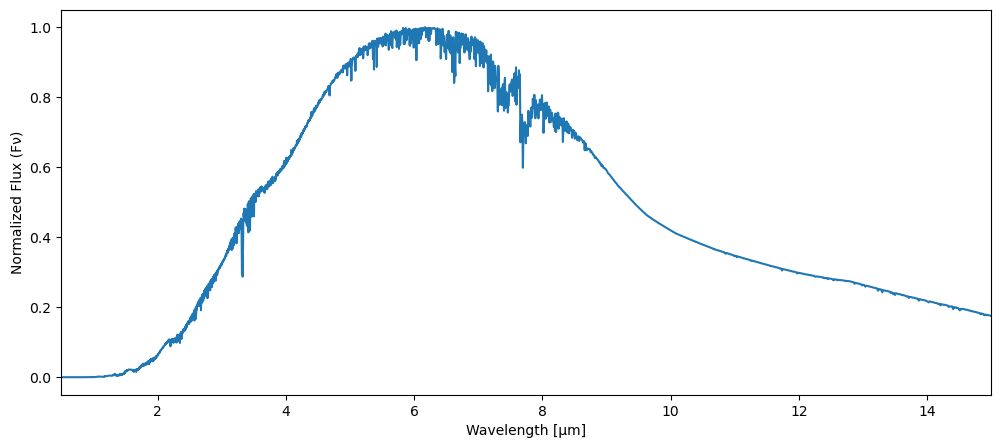

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))

λ = 1e4/wno_bin
plt.plot(λ, fp_bin/np.max(fp_bin))

plt.xlabel("Wavelength [μm]")
plt.ylabel("Normalized Flux (Fν)")
plt.xlim(.5, 15)
plt.show()

Similarly, here is the spectrum instead plotted as brightness temperature

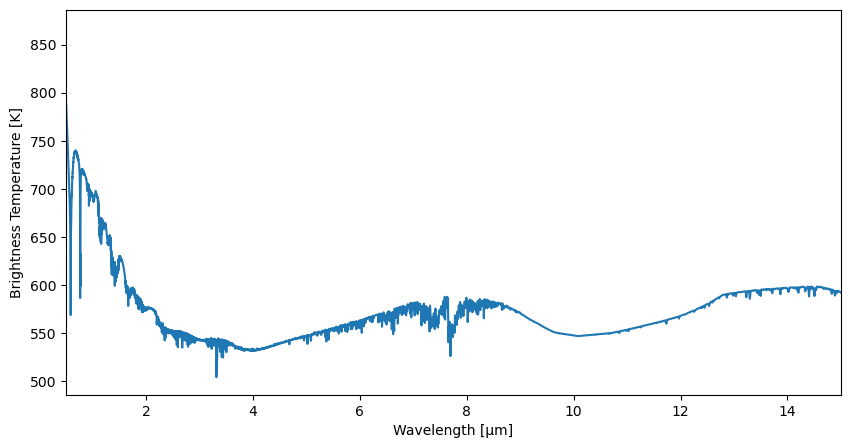

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))


λ = 1e4/wno_bin
T = jpi.brightness_temperature({"wavenumber": wno, 
                                "thermal": fp},
                                R=R, 
                                plot=False)

plt.plot(λ, T)

plt.xlabel("Wavelength [μm]")
plt.ylabel("Brightness Temperature [K]")
plt.xlim(.5, 15)
plt.show()